In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM, z_at_value 
import astropy.units as u

data = pd.read_csv('./DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
df = df[df['Use'] == 1] # 13,299
df = df[df['FKs'] > 0] # 12,676

mag_lim = 25.9 # apparent magnitude limit (same as AB magnitude limit)
redshift_bins = [(0, 0.3), (0.3, 0.45), (0.45, 0.6), (0.6, 0.8), 
                 (0.8, 1.0), (1.0, 1.2), (1.2, 1.7), (1.7, 2.0),
                 (2.0, 2.5), (2.5, 3.0), (3.0, 4.2), (4.2, 6.0)]
survey_area = 0.03556 # survey area in square degrees
min_count = 10 # minimum number of galaxies in a bin
lum_bin_edges = np.arange(18, 25, 0.25) # luminosity bin edges
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

mask_z = (df['zpk'] > redshift_bins[0][0]) & (df['zpk'] < redshift_bins[-1][1])
df = df[mask_z]

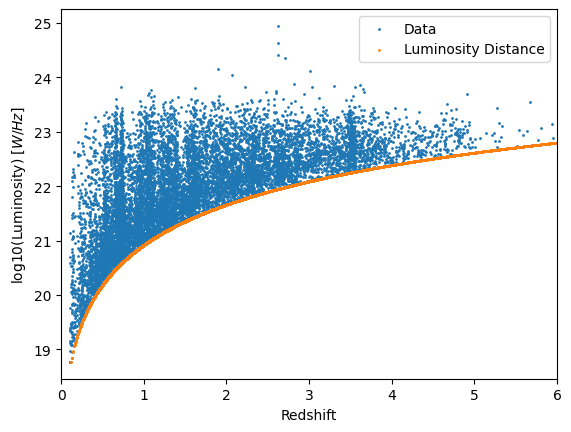

In [169]:
# Mask AB mag limit
mag_ab = 25 - 2.5*np.log10(df['FKs']) # apparent magnitude -> AB magnitude
mask = (mag_ab <= mag_lim)
fks = df['FKs'].values[mask] # apparent magnitude
z = df['zpk'].values[mask] # redshift
f = 0.3631 * fks * 10**-32  # uJy -> W/m^2/Hz

# Luminosity Distance
d = cosmo.luminosity_distance(z).to(u.m).value # meters
luminosity = 4 * np.pi * (d**2) * f # m^2 * W/m^2/Hz = W/Hz

# Calculate flux limit
f_lim = 10 ** ((mag_lim + 56.1) / -2.5) # AB mag -> W/m^2/Hz

# Maximum luminosity distance
dmaxs = np.sqrt(luminosity / (4*np.pi*f_lim)) # meters
zmaxs = z_at_value(cosmo.luminosity_distance, dmaxs * u.m).value

plt.scatter(z, np.log10(luminosity), s=1, label='Data')
plt.scatter(zmaxs, np.log10(luminosity), s=1, label='Luminosity Distance')
plt.ylabel('log10(Luminosity) $[W/Hz]$')
plt.xlabel('Redshift')
plt.xlim(0, 6)
plt.legend()
plt.show()

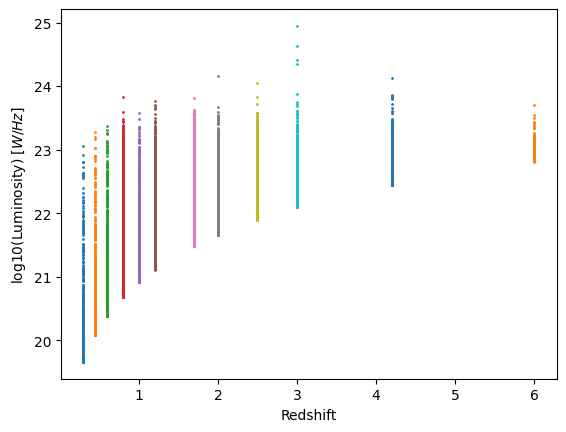

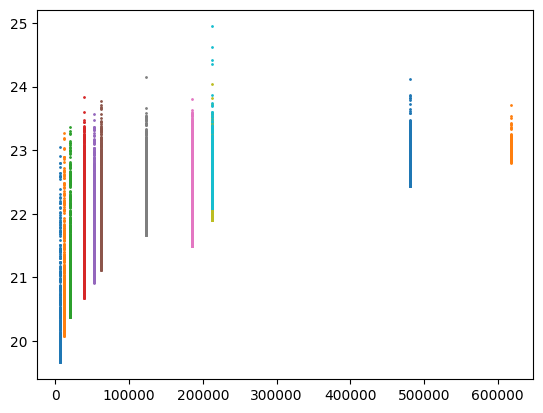

In [170]:
all_data = []
for z_start, z_end in redshift_bins:
    
    # Mask redshift
    mask_z = (z >= z_start) & (z < z_end)

    # Mask maximum redshift to the end of the redshift bin
    bin_zmaxs = zmaxs[mask_z]
    bin_zmaxs[bin_zmaxs > z_end] = z_end
    
    # Mask minimum redshift to end of the redshift bin
    mask_d = (bin_zmaxs == max(bin_zmaxs))
    bin_zmaxs = bin_zmaxs[mask_d]

    # Find the maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_start).value # Mpc
    dmaxs = cosmo.comoving_distance(bin_zmaxs).value # Mpc
    
    # Calculate the minimum & maximum volume -
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3 - of the redshift bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3 - of each galaxy
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    # Save data
    all_data.append([vol, np.log10(luminosity[mask_z][mask_d])])

    # Plot maximum data
    plt.scatter(bin_zmaxs, np.log10(luminosity[mask_z][mask_d]), s=1)
    
plt.ylabel('log10(Luminosity) $[W/Hz]$')
plt.xlabel('Redshift')
plt.show()

for vol, lum in all_data:
    plt.scatter(vol, lum, s=1)
plt.show()

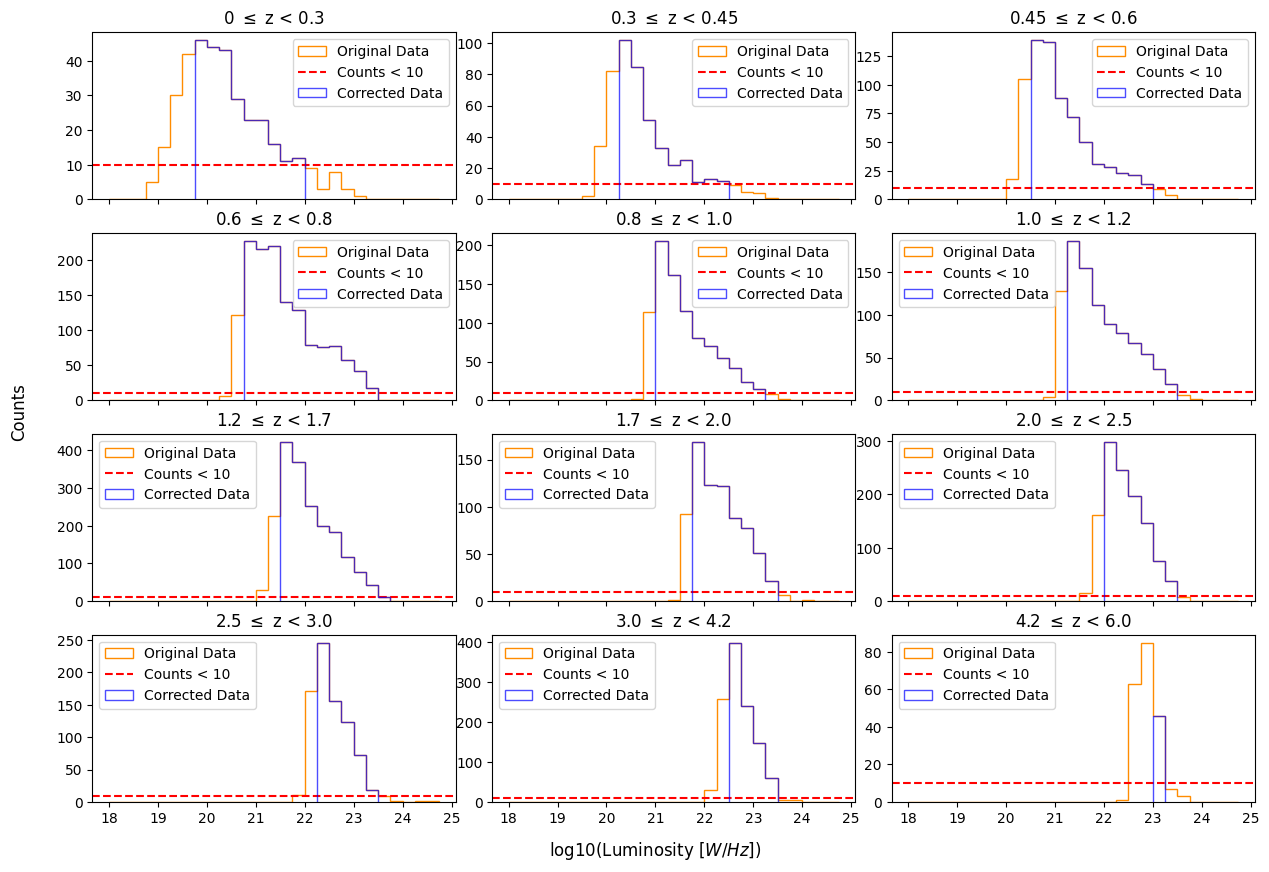

In [171]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True)
bin_edges = []
for (z_start, z_end), (vol, lum), ax in zip(redshift_bins, all_data, axes.flatten()):
    
    # Bin the original data per redshift bin
    _, b, _ = ax.hist(np.log10(luminosity)[(z >= z_start) & (z < z_end)], bins=lum_bin_edges, histtype='step', label='Original Data', color='darkorange')
    
    # Bin the new data with the same bins
    c, b = np.histogram(lum, bins=b)
    centers = (b[:-1] + b[1:]) / 2 # bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    for _ in range(2): # should only need to run twice
        nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
        c_mask[np.where(c_mask)[0][nci + 1]] = False
    
    b = b[1:][c_mask] # this [1:] removes the first bin edge which is impacted by the mask (would be a fraction of the bin width)
    centers = centers[c_mask]
    c = c[c_mask]
    
    # Plot the mask cutoff
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    # ax.axvline(np.log10(lum_lim(z_end)), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(lum_lim(z_end)), 2)}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    
    # Skip if there are no bins
    if len(c) == 0:
        ax.legend()
        continue
    
    # Plot the new, corrected data
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.7)
    ax.legend()
    bin_edges.append(b)

fig.supylabel('Counts', x=0.07)
fig.supxlabel('log10(Luminosity [$W/Hz$])', y=0.05)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()

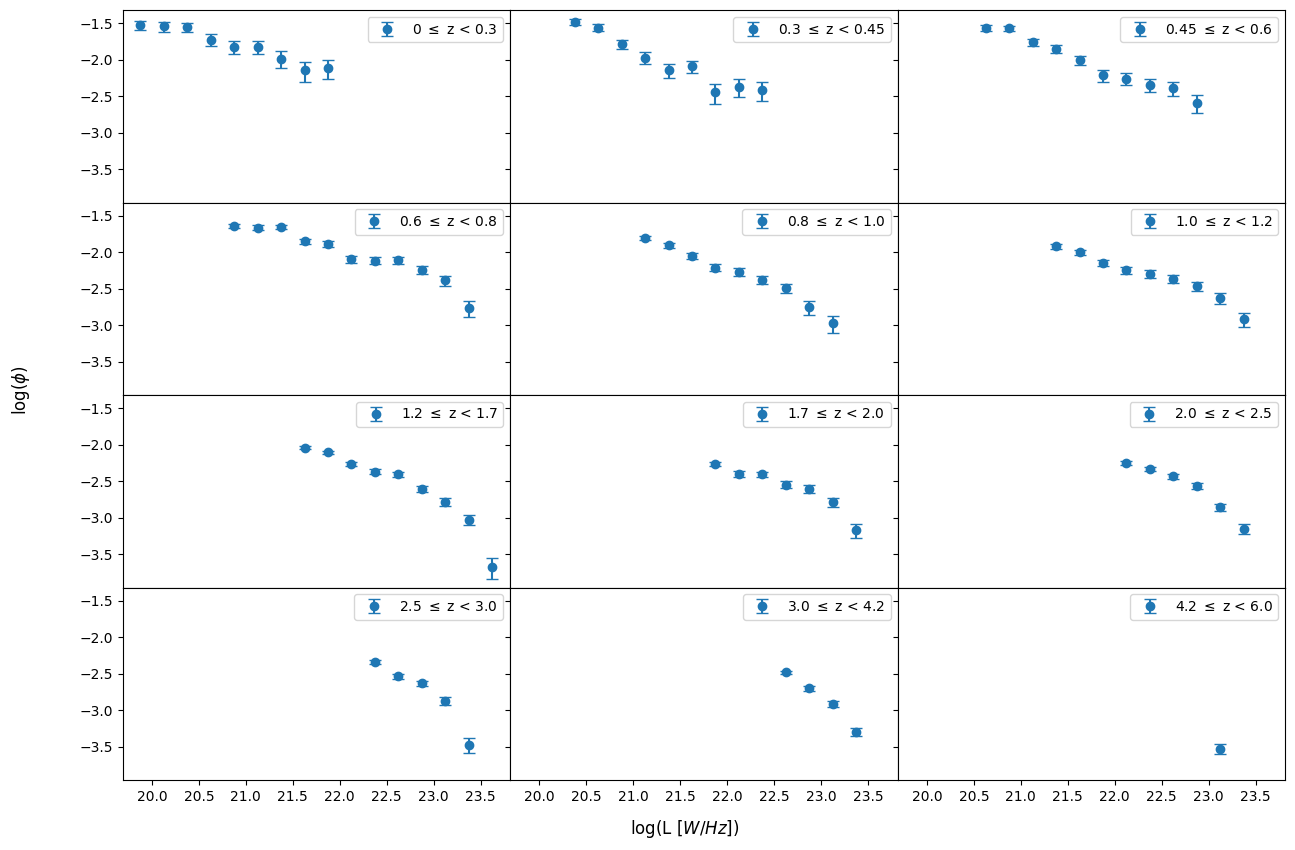

In [172]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin, in zip(all_data, bin_edges):
    
    # delta_log_l = np.diff(np.log10(np.abs(bin[::-1])))[0]
    if len(bin) <= 1:
        continue
    delta_log_l = np.diff(bin)[0]
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lum >= lum_start) & (lum < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.legend()

fig.supxlabel('log(L [$W/Hz$])', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)